In [ ]:
import zipfile

# Replace 'your_zip_file.zip' with the actual name of your zip file.
zip_file_path = '/content/drive/MyDrive/Chest X-Ray Images.zip'

# Specify the target directory where you want to extract the contents.
# You can change the 'target_directory' as needed.
target_directory = 'your_target_directory'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_directory)

# List the contents of the target directory to verify the extraction.
import os
extracted_files = os.listdir(target_directory)
print(extracted_files)


['chest_xray']


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

# Data directories
train_dir = '/content/your_target_directory/chest_xray/train'
test_dir = '/content/your_target_directory/chest_xray/test'

In [ ]:
# Data directories
train_dir = '/content/your_target_directory/chest_xray/train'
test_dir = '/content/your_target_directory/chest_xray/test'

In [ ]:
# Hyperparameters
image_size = (224, 224)
batch_size = 32
epochs = 5
learning_rate = 0.0001

In [ ]:
# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Pre-trained model (VGG16)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tuning the pre-trained model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# Training the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator
)

Epoch 1/5
163/163 [==============================] - 164s 979ms/step - loss: 0.0840 - accuracy: 0.9695 - val_loss: 0.3185 - val_accuracy: 0.9215
Epoch 2/5
163/163 [==============================] - 142s 869ms/step - loss: 0.0772 - accuracy: 0.9714 - val_loss: 0.2603 - val_accuracy: 0.9215
Epoch 3/5
163/163 [==============================] - 145s 890ms/step - loss: 0.0778 - accuracy: 0.9705 - val_loss: 0.3113 - val_accuracy: 0.9087
Epoch 4/5
163/163 [==============================] - 139s 849ms/step - loss: 0.0674 - accuracy: 0.9758 - val_loss: 0.2385 - val_accuracy: 0.9295
Epoch 5/5
163/163 [==============================] - 142s 867ms/step - loss: 0.0712 - accuracy: 0.9764 - val_loss: 0.2119 - val_accuracy: 0.9311


In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print()
print("======================================")
print()
print(f"Test Loss: {test_loss}")
print()
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


20/20 [==============================] - 5s 242ms/step - loss: 0.2119 - accuracy: 0.9311


Test Loss: 0.211885005235672

Test Accuracy: 93.11%


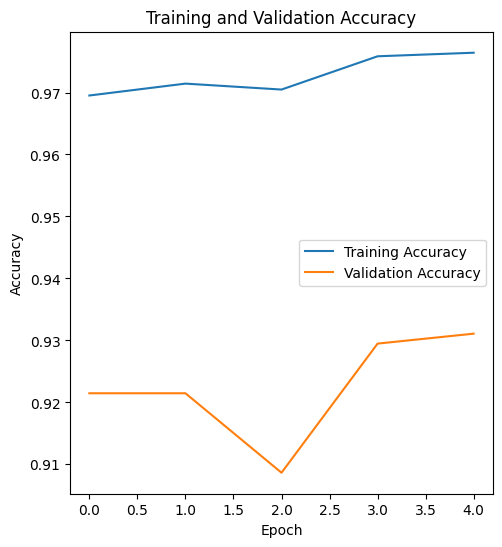

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


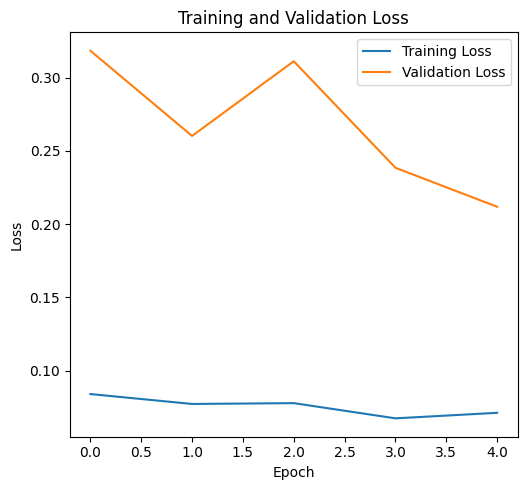

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save the model
model.save('pneumonia_detection_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the pre-trained model
model = load_model('pneumonia_detection_model.h5')  # Update with the actual model filename

# View the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 27560769 (105.14 MB)
Trainable params: 27560769 (105.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('pneumonia_detection_model.h5')

# Predict on the test data
predictions = model.predict(test_generator)
predicted_classes = np.round(predictions)

# Get the true labels
true_classes = test_generator.classes

# Generate a classification report
class_names = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_names)

# Generate a confusion matrix
confusion = confusion_matrix(true_classes, predicted_classes)

In [ ]:
print("\nConfusion Matrix:\n")
print(confusion)


Confusion Matrix:

[[198  36]
 [  9 381]]


In [ ]:
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.96      0.85      0.90       234
   PNEUMONIA       0.91      0.98      0.94       390

    accuracy                           0.93       624
   macro avg       0.94      0.91      0.92       624
weighted avg       0.93      0.93      0.93       624



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

import matplotlib.pyplot as plt

In [ ]:
# Load the pre-trained model
saved_model = load_model('pneumonia_detection_model.h5')  # Update with the actual model filename

In [ ]:
# Function to make predictions on a single image
def predict_pneumonia(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize the image

    prediction = saved_model.predict(img)

    if prediction > 0.5:
        return "Pneumonia (PN)"
    else:
        return "No Pneumonia (Non-PN)"

    # Display the image along with the prediction result
    plt.imshow(image.load_img(image_path))
    plt.title(f'Prediction: {result}')
    plt.axis('off')
    plt.show()

In [ ]:
# Provide the path to the image you want to predict
image_path = '/content/your_target_directory/chest_xray/train/PNEUMONIA/person1006_bacteria_2937.jpeg'  # Update with the actual image file path

result = predict_pneumonia(image_path)
print(f'This image is predicted as: {result}')

1/1 [==============================] - 1s 752ms/step
This image is predicted as: No Pneumonia (Non-PN)


1/1 [==============================] - 0s 148ms/step


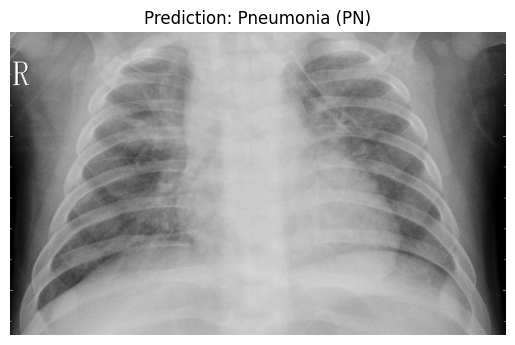

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the pre-trained model
saved_model = load_model('pneumonia_detection_model.h5')  # Update with the actual model filename

# Function to make predictions on a single image
def predict_pneumonia(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # Normalize the image

    prediction = saved_model.predict(img)

    return prediction

# Provide the path to the image you want to predict
image_path = '/content/your_target_directory/chest_xray/train/PNEUMONIA/person1003_virus_1685.jpeg'  # Update with the actual image file path


prediction = predict_pneumonia(image_path)

# Display the image along with the prediction result
img = image.load_img(image_path)
plt.imshow(img)
if prediction > 0.5:
    result = "Pneumonia (PN)"
else:
    result = "No Pneumonia (Non-PN)"
plt.title(f'Prediction: {result}')
plt.axis('off')
plt.show()


In [ ]:
import numpy as np

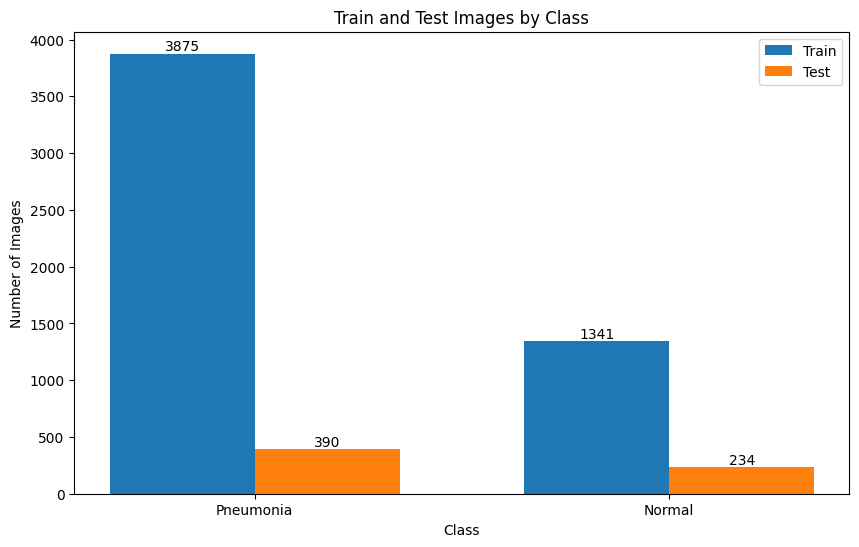

In [ ]:
import matplotlib.pyplot as plt
import os

# Get the number of training and test images for each class
train_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
train_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
test_pneumonia = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
test_normal = len(os.listdir(os.path.join(test_dir, 'NORMAL')))

# Define the class labels
class_labels = ['Pneumonia', 'Normal']

# Count of images for each class
train_counts = [train_pneumonia, train_normal]
test_counts = [test_pneumonia, test_normal]

# Create bar graph
plt.figure(figsize=(10, 6))
width = 0.35
x = range(len(class_labels))
plt.bar(x, train_counts, width, label='Train', align='center')
plt.bar([i + width for i in x], test_counts, width, label='Test', align='center')

plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Train and Test Images by Class')

# Add the count labels on top of the bars
for i, v in enumerate(train_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')
for i, v in enumerate(test_counts):
    plt.text(i + width, v, str(v), ha='center', va='bottom')

plt.xticks([i + width/2 for i in x], class_labels)
plt.legend()
plt.show()
